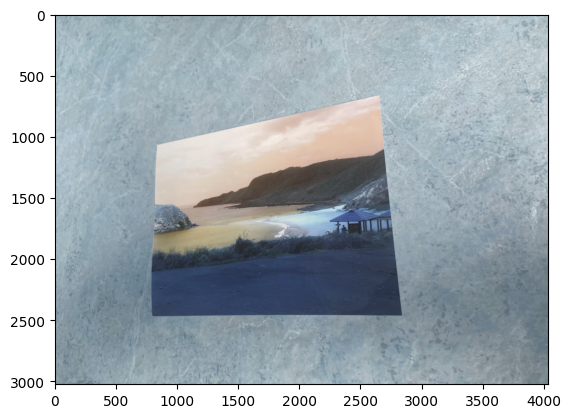

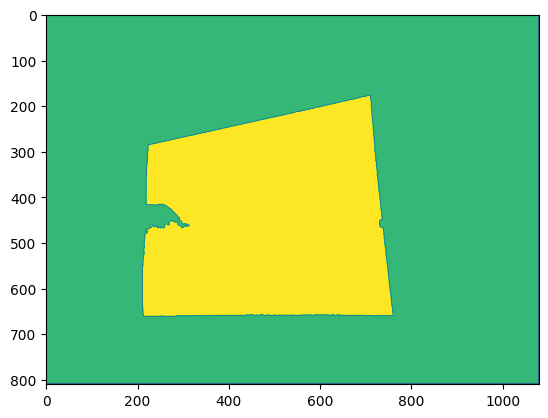

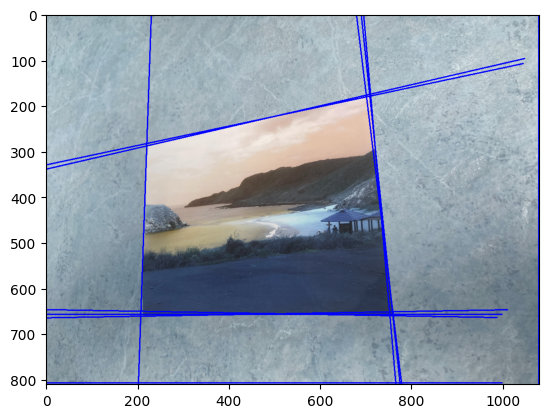

[(-1, 807), (1079, 807), (775, 807), (766, 807)]


In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def get_intersection(line1, line2):
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([[np.cos(theta1), np.sin(theta1)],
                 [np.cos(theta2), np.sin(theta2)]])
    b = np.array([[rho1], [rho2]])
    x, y = np.linalg.solve(A, b)
    x, y = int(x), int(y)
    return (x, y)


# read and display image
original = cv2.imread('./img/foto1_cap1.jpg')
plt.imshow(original)
plt.show()

# resize image to workable size
dim_limit = 1080
max_dim = max(original.shape[:2])
if max_dim > dim_limit:
    resize_scale = dim_limit / max_dim
    original = cv2.resize(original, None, fx=resize_scale, fy=resize_scale)

# convert image to grayscale/blurred versions
gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image to create a binary image
ret, thresh = cv2.threshold(
    blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# perform morphological transformations to remove noise
kernel = np.ones((24, 24), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=3)

# sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=35)

# find sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

# find unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# add one to all labels so that sure background is not 0, but 1
markers = markers+1

# mark the region of unknown with zero
markers[unknown == 255] = 0

# watershed
watersheded = original.copy()
markers = cv2.watershed(watersheded, markers)
watersheded[markers == -1] = [255, 0, 0]

# display image with marker labels
plt.imshow(markers)
plt.show()

# generate mask image
mask = np.zeros(original.shape[:2], np.uint8)
mask[markers == -1] = 255

# perform hough line transform over the mask
lines = cv2.HoughLines(mask, 2, np.pi/180, 150)

# draw lines on the image
lined_img = original.copy()
for line in lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(lined_img, (x1, y1), (x2, y2), (0, 0, 255), 2)

# show the image with the lines drawn on it
plt.imshow(lined_img)
plt.show()

points = []

# iterate through all line combinations
for i, line1 in enumerate(lines):
    for j, line2 in enumerate(lines):
        if i == j:
            continue
        # check angle between lines
        angle = abs(line1[0][1] - line2[0][1])
        if angle > np.pi / 2:
            angle = abs(angle - np.pi)
        if angle < np.pi / 4:
            continue
        # find intersection point
        point = get_intersection(line1, line2)
        if point not in points:
            points.append(point)
            if len(points) == 4:
                break
    if len(points) == 4:
        break

print(points)


In [28]:
corners = original.copy()
for point in points:
    corners = cv2.circle(corners, point, radius=10, color=(0,0,255), thickness=-1)

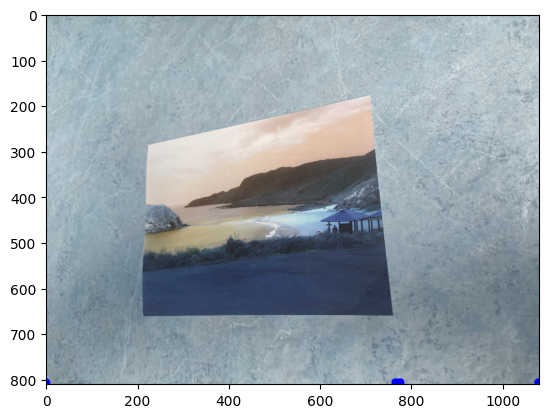

In [29]:
plt.imshow(corners)
plt.show()